# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

keywords are unexpanded, not using


In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -1.572326 -0.276459  0.0  0.687287 -0.297432 -0.300103  1  3  22.455789   
1  2.038347 -0.579333  1.0  0.847914 -0.454881  1.322657  2  2  37.958127   
2  0.521409 -1.607899  1.0  0.261555 -1.994843  1.775260  0  3  33.533321   
3 -0.068117 -1.930997  1.0  0.291588 -0.865465 -1.148724  1  3  24.102600   
4  0.643261  0.242097  1.0  0.731762 -0.537193 -0.092098  1  0  19.088376   

            y  
0   99.210708  
1  531.232852  
2  179.577943  
3   55.655902  
4  243.968410  
True causal estimate is 6.118369461806465


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

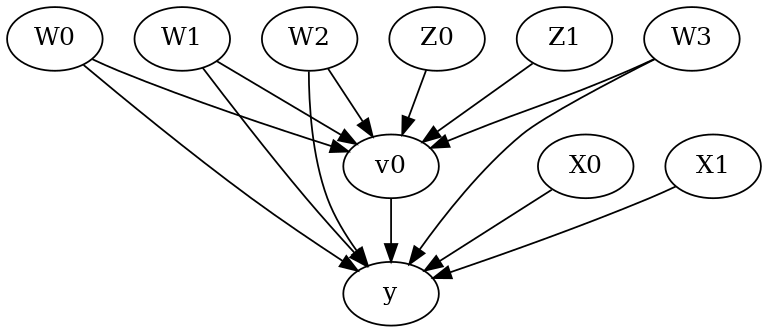

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X0', 'X1']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1+v0*X0+v0*X1
Target units: ate

## Estimate
Mean value: 6.118261947286108
### Conditional Estimates
__categorical__X0  __categorical__X1
(-4.533, -1.394]   (-4.15, -1.423]      -3.393360
                   (-1.423, -0.832]     -0.199065
                   (-0.832, -0.342]      1.903760
                   (-0.342, 0.253]       4.028011
                   (0.253, 3.386]        7.421209
(-1.394, -0.806]   (-4.15, -1.423]      -0.960558
                   (-1.423, -0.832]      2.558583
                   (-0.832, -0.342]      4.460922
                   (-0.342, 0.253]       6.535613
                   (0.253, 3.386]       10.03164

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 12.302810992638177
Effect estimates: [13.86797915 20.2033344   9.25575676 10.21736627  7.87971234  7.98301403
 11.90772361  5.29039365 10.84756733  8.90868587  4.96964745 14.27013483
 16.47502755 19.94699143  4.33749096 19.37889512 15.72817721  8.79084705
 11.5306224  26.0892967  15.50115461 13.47461261  9.34643725 14.09944046
 13.61426384 10.8779358  13.03740662  8.85596919 12.90516594 17.1794349
  8.48061411 14.5456503  10.76423598  8.97404768  8.55118778  9.32398528
 12.91415075 11.00502657 14.6608963  15.38524251 12.19813131  2.49401858
  4.82

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 6.118369461806465


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X0,X1
Target units: 

## Estimate
Mean value: 6.2097711635208475
Effect estimates: [ 4.36749158 13.98388477  5.30141766 ...  9.95931217  6.67286419
 -0.91356306]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 6.22307658849953
Effect estimates: [ 4.39738956 13.90467249  5.34332321 ...  9.91231964  6.67980695
 -0.79242519]
95.0% confidence interval: (array([ 4.31179874, 13.79679603,  5.27750384, ...,  9.90957471,
        6.7256337 , -0.94744259]), array([ 4.62761219, 14.56531445,  5.67813296, ..., 10.26468978,
        6.90970963, -0.55722522]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[12.75301129 14.486491   15.65434241 14.33026986 13.57552497 16.71672737
 12.70936181 14.2039103  14.23143698 15.12953011]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.528393  0.373845  1.0  0.524787 -0.509900  0.230459 -0.005209   
1    -0.525059  0.665665  1.0  0.796246  1.582520 -0.626983  1.275259   
2     0.251581  2.567826  0.0  0.700689  1.119652 -2.413175  0.595198   
3     0.197340  1.320741  1.0  0.788653  0.934593 -1.718688 -0.889255   
4    -0.264730 -0.054459  1.0  0.686501 -0.477016  0.201512 -0.176500   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.294732 -0.504828  1.0  0.574093  0.360858  0.179506 -0.027301   
9996  0.930848  1.304874  1.0  0.462798  0.347386  1.063402 -0.672607   
9997  2.220763 -0.144306  1.0  0.285696  2.360875 -0.941507 -0.205773   
9998  0.944089 -0.512548  1.0  0.412948  0.348259 -2.333894 -2.121014   
9999  1.578899  0.915673  1.0  0.850406  1.715599 -1.243528  0.422444   

            W3  v0  y  
0     1.082407   1  1  
1     1.650731   1  1  
2     2.171664   1  1  
3     3.133830   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W0,W3,W2,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W2,W1,U) = P(y|v0,W0,W3,W2,W1)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X0,X1
Target units: ate

## Estimate
Mean value: 0.4417443613339107
Effect estimates: [0.41084031 0.42408052 0.73892403 ... 0.38200531 0.28737642 0.52531907]

True causal estimate is 0.4263


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-03 14:38:36.154482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-03 14:38:36.154527: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-03 14:38:37.985810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /__t/Python/3.10.5/x64/lib
2022-08-03 14:38:37.985853: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-03 14:38:37.985879: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (edc217d4b2c5): /proc/driver/nvidia/version does not exist
2022-08-03 14:38:37.986153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:18 - loss: 317.1870

 26/313 [=>............................] - ETA: 0s - loss: 103.1579  

 51/313 [===>..........................] - ETA: 0s - loss: 56.3924 

 77/313 [======>.......................] - ETA: 0s - loss: 39.1549

104/313 [========>.....................] - ETA: 0s - loss: 30.2725

126/313 [===========>..................] - ETA: 0s - loss: 25.8410

151/313 [=============>................] - ETA: 0s - loss: 22.3390

172/313 [===============>..............] - ETA: 0s - loss: 20.1840

196/313 [=================>............] - ETA: 0s - loss: 18.2930

221/313 [====================>.........] - ETA: 0s - loss: 16.7604

246/313 [======================>.......] - ETA: 0s - loss: 15.5307

272/313 [=========================>....] - ETA: 0s - loss: 14.4808

298/313 [===========================>..] - ETA: 0s - loss: 13.6127

313/313 [==============================] - 1s 2ms/step - loss: 13.1816


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.1984

 24/313 [=>............................] - ETA: 0s - loss: 4.5455

 49/313 [===>..........................] - ETA: 0s - loss: 4.5486

 75/313 [======>.......................] - ETA: 0s - loss: 4.5079

102/313 [========>.....................] - ETA: 0s - loss: 4.4819

127/313 [===========>..................] - ETA: 0s - loss: 4.4613

149/313 [=============>................] - ETA: 0s - loss: 4.4465

175/313 [===============>..............] - ETA: 0s - loss: 4.4230

199/313 [==================>...........] - ETA: 0s - loss: 4.4141

223/313 [====================>.........] - ETA: 0s - loss: 4.3924

249/313 [======================>.......] - ETA: 0s - loss: 4.3625

272/313 [=========================>....] - ETA: 0s - loss: 4.3381

298/313 [===========================>..] - ETA: 0s - loss: 4.3140

313/313 [==============================] - 1s 2ms/step - loss: 4.3013


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.6577

 28/313 [=>............................] - ETA: 0s - loss: 3.9027

 53/313 [====>.........................] - ETA: 0s - loss: 3.8986

 75/313 [======>.......................] - ETA: 0s - loss: 3.8799

101/313 [========>.....................] - ETA: 0s - loss: 3.8337

126/313 [===========>..................] - ETA: 0s - loss: 3.7809

151/313 [=============>................] - ETA: 0s - loss: 3.7130

176/313 [===============>..............] - ETA: 0s - loss: 3.6410

198/313 [=================>............] - ETA: 0s - loss: 3.5845

223/313 [====================>.........] - ETA: 0s - loss: 3.5323

249/313 [======================>.......] - ETA: 0s - loss: 3.4910

274/313 [=========================>....] - ETA: 0s - loss: 3.4578

298/313 [===========================>..] - ETA: 0s - loss: 3.4227

313/313 [==============================] - 1s 2ms/step - loss: 3.4048


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.9388

 26/313 [=>............................] - ETA: 0s - loss: 3.0330

 52/313 [===>..........................] - ETA: 0s - loss: 3.0349

 76/313 [======>.......................] - ETA: 0s - loss: 3.0407

101/313 [========>.....................] - ETA: 0s - loss: 3.0590

126/313 [===========>..................] - ETA: 0s - loss: 3.0458

151/313 [=============>................] - ETA: 0s - loss: 3.0445

176/313 [===============>..............] - ETA: 0s - loss: 3.0486

201/313 [==================>...........] - ETA: 0s - loss: 3.0443

227/313 [====================>.........] - ETA: 0s - loss: 3.0396

252/313 [=======================>......] - ETA: 0s - loss: 3.0276

278/313 [=========================>....] - ETA: 0s - loss: 3.0263

303/313 [============================>.] - ETA: 0s - loss: 3.0218

313/313 [==============================] - 1s 2ms/step - loss: 3.0199


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.9859

 26/313 [=>............................] - ETA: 0s - loss: 2.9346

 52/313 [===>..........................] - ETA: 0s - loss: 2.9700

 79/313 [======>.......................] - ETA: 0s - loss: 2.9761

104/313 [========>.....................] - ETA: 0s - loss: 2.9781

129/313 [===========>..................] - ETA: 0s - loss: 2.9703

153/313 [=============>................] - ETA: 0s - loss: 2.9654

178/313 [================>.............] - ETA: 0s - loss: 2.9632

203/313 [==================>...........] - ETA: 0s - loss: 2.9517

229/313 [====================>.........] - ETA: 0s - loss: 2.9547

253/313 [=======================>......] - ETA: 0s - loss: 2.9588

277/313 [=========================>....] - ETA: 0s - loss: 2.9501

296/313 [===========================>..] - ETA: 0s - loss: 2.9491

313/313 [==============================] - 1s 2ms/step - loss: 2.9517


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.8178

 22/313 [=>............................] - ETA: 0s - loss: 2.9034

 47/313 [===>..........................] - ETA: 0s - loss: 2.8955

 71/313 [=====>........................] - ETA: 0s - loss: 2.8890

 93/313 [=======>......................] - ETA: 0s - loss: 2.9020

113/313 [=========>....................] - ETA: 0s - loss: 2.9108

138/313 [============>.................] - ETA: 0s - loss: 2.9168

162/313 [==============>...............] - ETA: 0s - loss: 2.9164

186/313 [================>.............] - ETA: 0s - loss: 2.9179

212/313 [===================>..........] - ETA: 0s - loss: 2.9136

238/313 [=====================>........] - ETA: 0s - loss: 2.9074

262/313 [========================>.....] - ETA: 0s - loss: 2.9087

287/313 [==========================>...] - ETA: 0s - loss: 2.9078

311/313 [============================>.] - ETA: 0s - loss: 2.9073

313/313 [==============================] - 1s 2ms/step - loss: 2.9073


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.7051

 27/313 [=>............................] - ETA: 0s - loss: 2.8026

 51/313 [===>..........................] - ETA: 0s - loss: 2.8639

 75/313 [======>.......................] - ETA: 0s - loss: 2.8740

 99/313 [========>.....................] - ETA: 0s - loss: 2.8677

124/313 [==========>...................] - ETA: 0s - loss: 2.8680

150/313 [=============>................] - ETA: 0s - loss: 2.8784

173/313 [===============>..............] - ETA: 0s - loss: 2.8869

196/313 [=================>............] - ETA: 0s - loss: 2.8881

221/313 [====================>.........] - ETA: 0s - loss: 2.8959

245/313 [======================>.......] - ETA: 0s - loss: 2.8936

271/313 [========================>.....] - ETA: 0s - loss: 2.8937

295/313 [===========================>..] - ETA: 0s - loss: 2.8919

313/313 [==============================] - 1s 2ms/step - loss: 2.8886


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.7449

 24/313 [=>............................] - ETA: 0s - loss: 2.8431

 47/313 [===>..........................] - ETA: 0s - loss: 2.8537

 72/313 [=====>........................] - ETA: 0s - loss: 2.8406

 96/313 [========>.....................] - ETA: 0s - loss: 2.8387

122/313 [==========>...................] - ETA: 0s - loss: 2.8309

146/313 [============>.................] - ETA: 0s - loss: 2.8339

171/313 [===============>..............] - ETA: 0s - loss: 2.8379

194/313 [=================>............] - ETA: 0s - loss: 2.8336

220/313 [====================>.........] - ETA: 0s - loss: 2.8310

245/313 [======================>.......] - ETA: 0s - loss: 2.8323

271/313 [========================>.....] - ETA: 0s - loss: 2.8345

297/313 [===========================>..] - ETA: 0s - loss: 2.8343

313/313 [==============================] - 1s 2ms/step - loss: 2.8372


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.6556

 27/313 [=>............................] - ETA: 0s - loss: 2.7554

 53/313 [====>.........................] - ETA: 0s - loss: 2.8053

 78/313 [======>.......................] - ETA: 0s - loss: 2.8063

103/313 [========>.....................] - ETA: 0s - loss: 2.8097

125/313 [==========>...................] - ETA: 0s - loss: 2.8165

150/313 [=============>................] - ETA: 0s - loss: 2.8065

174/313 [===============>..............] - ETA: 0s - loss: 2.8125

199/313 [==================>...........] - ETA: 0s - loss: 2.8138

225/313 [====================>.........] - ETA: 0s - loss: 2.8135

250/313 [======================>.......] - ETA: 0s - loss: 2.8175

276/313 [=========================>....] - ETA: 0s - loss: 2.8171

302/313 [===========================>..] - ETA: 0s - loss: 2.8151

313/313 [==============================] - 1s 2ms/step - loss: 2.8143


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.9027

 26/313 [=>............................] - ETA: 0s - loss: 2.7367

 49/313 [===>..........................] - ETA: 0s - loss: 2.7773

 70/313 [=====>........................] - ETA: 0s - loss: 2.7795

 93/313 [=======>......................] - ETA: 0s - loss: 2.7694

116/313 [==========>...................] - ETA: 0s - loss: 2.7745

138/313 [============>.................] - ETA: 0s - loss: 2.7812

164/313 [==============>...............] - ETA: 0s - loss: 2.7863

188/313 [=================>............] - ETA: 0s - loss: 2.7840

214/313 [===================>..........] - ETA: 0s - loss: 2.7839

239/313 [=====================>........] - ETA: 0s - loss: 2.7843

262/313 [========================>.....] - ETA: 0s - loss: 2.7881

288/313 [==========================>...] - ETA: 0s - loss: 2.7892

313/313 [==============================] - 1s 2ms/step - loss: 2.7870


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.8776

 27/313 [=>............................] - ETA: 0s - loss: 2.7639

 52/313 [===>..........................] - ETA: 0s - loss: 2.7865

 77/313 [======>.......................] - ETA: 0s - loss: 2.7844

102/313 [========>.....................] - ETA: 0s - loss: 2.7837

125/313 [==========>...................] - ETA: 0s - loss: 2.7807

149/313 [=============>................] - ETA: 0s - loss: 2.7781

168/313 [===============>..............] - ETA: 0s - loss: 2.7819

192/313 [=================>............] - ETA: 0s - loss: 2.7838

218/313 [===================>..........] - ETA: 0s - loss: 2.7841

244/313 [======================>.......] - ETA: 0s - loss: 2.7830

270/313 [========================>.....] - ETA: 0s - loss: 2.7852

294/313 [===========================>..] - ETA: 0s - loss: 2.7824

313/313 [==============================] - 1s 2ms/step - loss: 2.7783


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7246

 28/313 [=>............................] - ETA: 0s - loss: 2.7964

 53/313 [====>.........................] - ETA: 0s - loss: 2.7762

 79/313 [======>.......................] - ETA: 0s - loss: 2.7910

104/313 [========>.....................] - ETA: 0s - loss: 2.7719

127/313 [===========>..................] - ETA: 0s - loss: 2.7625

151/313 [=============>................] - ETA: 0s - loss: 2.7523

178/313 [================>.............] - ETA: 0s - loss: 2.7491

204/313 [==================>...........] - ETA: 0s - loss: 2.7494

230/313 [=====================>........] - ETA: 0s - loss: 2.7528

255/313 [=======================>......] - ETA: 0s - loss: 2.7526

281/313 [=========================>....] - ETA: 0s - loss: 2.7519

307/313 [============================>.] - ETA: 0s - loss: 2.7520

313/313 [==============================] - 1s 2ms/step - loss: 2.7544


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.9138

 25/313 [=>............................] - ETA: 0s - loss: 2.7452

 50/313 [===>..........................] - ETA: 0s - loss: 2.7332

 73/313 [=====>........................] - ETA: 0s - loss: 2.7277

 99/313 [========>.....................] - ETA: 0s - loss: 2.7193

121/313 [==========>...................] - ETA: 0s - loss: 2.7230

147/313 [=============>................] - ETA: 0s - loss: 2.7174

172/313 [===============>..............] - ETA: 0s - loss: 2.7212

198/313 [=================>............] - ETA: 0s - loss: 2.7167

222/313 [====================>.........] - ETA: 0s - loss: 2.7175

247/313 [======================>.......] - ETA: 0s - loss: 2.7203

270/313 [========================>.....] - ETA: 0s - loss: 2.7238

294/313 [===========================>..] - ETA: 0s - loss: 2.7245

313/313 [==============================] - 1s 2ms/step - loss: 2.7259


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.6783

 26/313 [=>............................] - ETA: 0s - loss: 2.7079

 51/313 [===>..........................] - ETA: 0s - loss: 2.7098

 74/313 [======>.......................] - ETA: 0s - loss: 2.7109

 99/313 [========>.....................] - ETA: 0s - loss: 2.7144

122/313 [==========>...................] - ETA: 0s - loss: 2.7154

147/313 [=============>................] - ETA: 0s - loss: 2.7124

173/313 [===============>..............] - ETA: 0s - loss: 2.7113

198/313 [=================>............] - ETA: 0s - loss: 2.7065

219/313 [===================>..........] - ETA: 0s - loss: 2.7060

242/313 [======================>.......] - ETA: 0s - loss: 2.7087

266/313 [========================>.....] - ETA: 0s - loss: 2.7086

291/313 [==========================>...] - ETA: 0s - loss: 2.7043

313/313 [==============================] - 1s 2ms/step - loss: 2.7002


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.3751

 22/313 [=>............................] - ETA: 0s - loss: 2.6800

 44/313 [===>..........................] - ETA: 0s - loss: 2.6444

 68/313 [=====>........................] - ETA: 0s - loss: 2.6372

 92/313 [=======>......................] - ETA: 0s - loss: 2.6329

116/313 [==========>...................] - ETA: 0s - loss: 2.6325

142/313 [============>.................] - ETA: 0s - loss: 2.6362

165/313 [==============>...............] - ETA: 0s - loss: 2.6375

190/313 [=================>............] - ETA: 0s - loss: 2.6319

213/313 [===================>..........] - ETA: 0s - loss: 2.6358

238/313 [=====================>........] - ETA: 0s - loss: 2.6296

261/313 [========================>.....] - ETA: 0s - loss: 2.6290

284/313 [==========================>...] - ETA: 0s - loss: 2.6294

307/313 [============================>.] - ETA: 0s - loss: 2.6265

313/313 [==============================] - 1s 2ms/step - loss: 2.6256


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.3956

 25/313 [=>............................] - ETA: 0s - loss: 2.5873

 49/313 [===>..........................] - ETA: 0s - loss: 2.5894

 71/313 [=====>........................] - ETA: 0s - loss: 2.6044

 91/313 [=======>......................] - ETA: 0s - loss: 2.6067

114/313 [=========>....................] - ETA: 0s - loss: 2.6127

138/313 [============>.................] - ETA: 0s - loss: 2.6124

162/313 [==============>...............] - ETA: 0s - loss: 2.6120

187/313 [================>.............] - ETA: 0s - loss: 2.6048

211/313 [===================>..........] - ETA: 0s - loss: 2.6025

235/313 [=====================>........] - ETA: 0s - loss: 2.5980

261/313 [========================>.....] - ETA: 0s - loss: 2.5917

281/313 [=========================>....] - ETA: 0s - loss: 2.5931

304/313 [============================>.] - ETA: 0s - loss: 2.5941

313/313 [==============================] - 1s 2ms/step - loss: 2.5941


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.5852

 25/313 [=>............................] - ETA: 0s - loss: 2.5842

 51/313 [===>..........................] - ETA: 0s - loss: 2.5718

 73/313 [=====>........................] - ETA: 0s - loss: 2.5720

 95/313 [========>.....................] - ETA: 0s - loss: 2.5769

116/313 [==========>...................] - ETA: 0s - loss: 2.5771

140/313 [============>.................] - ETA: 0s - loss: 2.5763

163/313 [==============>...............] - ETA: 0s - loss: 2.5725

183/313 [================>.............] - ETA: 0s - loss: 2.5743

208/313 [==================>...........] - ETA: 0s - loss: 2.5742

228/313 [====================>.........] - ETA: 0s - loss: 2.5775

251/313 [=======================>......] - ETA: 0s - loss: 2.5793

275/313 [=========================>....] - ETA: 0s - loss: 2.5770

300/313 [===========================>..] - ETA: 0s - loss: 2.5762

313/313 [==============================] - 1s 2ms/step - loss: 2.5777


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.8430

 25/313 [=>............................] - ETA: 0s - loss: 2.5701

 48/313 [===>..........................] - ETA: 0s - loss: 2.5906

 71/313 [=====>........................] - ETA: 0s - loss: 2.5847

 93/313 [=======>......................] - ETA: 0s - loss: 2.5776

116/313 [==========>...................] - ETA: 0s - loss: 2.5873

139/313 [============>.................] - ETA: 0s - loss: 2.5828

162/313 [==============>...............] - ETA: 0s - loss: 2.5848

185/313 [================>.............] - ETA: 0s - loss: 2.5882

209/313 [===================>..........] - ETA: 0s - loss: 2.5916

233/313 [=====================>........] - ETA: 0s - loss: 2.5899

256/313 [=======================>......] - ETA: 0s - loss: 2.5897

278/313 [=========================>....] - ETA: 0s - loss: 2.5842

300/313 [===========================>..] - ETA: 0s - loss: 2.5850

313/313 [==============================] - 1s 2ms/step - loss: 2.5866


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.4329

 24/313 [=>............................] - ETA: 0s - loss: 2.5615

 47/313 [===>..........................] - ETA: 0s - loss: 2.5716

 71/313 [=====>........................] - ETA: 0s - loss: 2.5800

 96/313 [========>.....................] - ETA: 0s - loss: 2.5848

121/313 [==========>...................] - ETA: 0s - loss: 2.5750

145/313 [============>.................] - ETA: 0s - loss: 2.5759

169/313 [===============>..............] - ETA: 0s - loss: 2.5781

191/313 [=================>............] - ETA: 0s - loss: 2.5785

216/313 [===================>..........] - ETA: 0s - loss: 2.5743

240/313 [======================>.......] - ETA: 0s - loss: 2.5692

264/313 [========================>.....] - ETA: 0s - loss: 2.5677

287/313 [==========================>...] - ETA: 0s - loss: 2.5664

312/313 [============================>.] - ETA: 0s - loss: 2.5659

313/313 [==============================] - 1s 2ms/step - loss: 2.5658


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.4754

 26/313 [=>............................] - ETA: 0s - loss: 2.5791

 50/313 [===>..........................] - ETA: 0s - loss: 2.5855

 74/313 [======>.......................] - ETA: 0s - loss: 2.5979

 97/313 [========>.....................] - ETA: 0s - loss: 2.5968

119/313 [==========>...................] - ETA: 0s - loss: 2.5901

141/313 [============>.................] - ETA: 0s - loss: 2.5861

164/313 [==============>...............] - ETA: 0s - loss: 2.5781

186/313 [================>.............] - ETA: 0s - loss: 2.5741

208/313 [==================>...........] - ETA: 0s - loss: 2.5708

230/313 [=====================>........] - ETA: 0s - loss: 2.5700

250/313 [======================>.......] - ETA: 0s - loss: 2.5670

273/313 [=========================>....] - ETA: 0s - loss: 2.5685

297/313 [===========================>..] - ETA: 0s - loss: 2.5675

313/313 [==============================] - 1s 2ms/step - loss: 2.5652


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.9421

 26/313 [=>............................] - ETA: 0s - loss: 2.6049

 49/313 [===>..........................] - ETA: 0s - loss: 2.5791

 73/313 [=====>........................] - ETA: 0s - loss: 2.5680

 97/313 [========>.....................] - ETA: 0s - loss: 2.5598

119/313 [==========>...................] - ETA: 0s - loss: 2.5564

140/313 [============>.................] - ETA: 0s - loss: 2.5599

164/313 [==============>...............] - ETA: 0s - loss: 2.5605

188/313 [=================>............] - ETA: 0s - loss: 2.5577

212/313 [===================>..........] - ETA: 0s - loss: 2.5592

236/313 [=====================>........] - ETA: 0s - loss: 2.5588

262/313 [========================>.....] - ETA: 0s - loss: 2.5598

286/313 [==========================>...] - ETA: 0s - loss: 2.5571

310/313 [============================>.] - ETA: 0s - loss: 2.5547

313/313 [==============================] - 1s 2ms/step - loss: 2.5546


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.6228

 26/313 [=>............................] - ETA: 0s - loss: 2.5297

 50/313 [===>..........................] - ETA: 0s - loss: 2.5355

 71/313 [=====>........................] - ETA: 0s - loss: 2.5459

 91/313 [=======>......................] - ETA: 0s - loss: 2.5372

114/313 [=========>....................] - ETA: 0s - loss: 2.5365

137/313 [============>.................] - ETA: 0s - loss: 2.5383

160/313 [==============>...............] - ETA: 0s - loss: 2.5407

185/313 [================>.............] - ETA: 0s - loss: 2.5424

210/313 [===================>..........] - ETA: 0s - loss: 2.5440

234/313 [=====================>........] - ETA: 0s - loss: 2.5460

260/313 [=======================>......] - ETA: 0s - loss: 2.5448

284/313 [==========================>...] - ETA: 0s - loss: 2.5497

309/313 [============================>.] - ETA: 0s - loss: 2.5516

313/313 [==============================] - 1s 2ms/step - loss: 2.5529


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.5570

 27/313 [=>............................] - ETA: 0s - loss: 2.5632

 53/313 [====>.........................] - ETA: 0s - loss: 2.5426

 78/313 [======>.......................] - ETA: 0s - loss: 2.5575

103/313 [========>.....................] - ETA: 0s - loss: 2.5548

123/313 [==========>...................] - ETA: 0s - loss: 2.5548

147/313 [=============>................] - ETA: 0s - loss: 2.5532

169/313 [===============>..............] - ETA: 0s - loss: 2.5505

192/313 [=================>............] - ETA: 0s - loss: 2.5546

216/313 [===================>..........] - ETA: 0s - loss: 2.5536

239/313 [=====================>........] - ETA: 0s - loss: 2.5515

263/313 [========================>.....] - ETA: 0s - loss: 2.5505

287/313 [==========================>...] - ETA: 0s - loss: 2.5509

309/313 [============================>.] - ETA: 0s - loss: 2.5525

313/313 [==============================] - 1s 2ms/step - loss: 2.5532


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.5621

 26/313 [=>............................] - ETA: 0s - loss: 2.5676

 49/313 [===>..........................] - ETA: 0s - loss: 2.5676

 73/313 [=====>........................] - ETA: 0s - loss: 2.5537

 98/313 [========>.....................] - ETA: 0s - loss: 2.5477

122/313 [==========>...................] - ETA: 0s - loss: 2.5493

145/313 [============>.................] - ETA: 0s - loss: 2.5498

168/313 [===============>..............] - ETA: 0s - loss: 2.5538

192/313 [=================>............] - ETA: 0s - loss: 2.5469

215/313 [===================>..........] - ETA: 0s - loss: 2.5486

239/313 [=====================>........] - ETA: 0s - loss: 2.5496

262/313 [========================>.....] - ETA: 0s - loss: 2.5510

284/313 [==========================>...] - ETA: 0s - loss: 2.5528

309/313 [============================>.] - ETA: 0s - loss: 2.5527

313/313 [==============================] - 1s 2ms/step - loss: 2.5517


Epoch 25/25


  1/313 [..............................] - ETA: 0s - loss: 2.5013

 26/313 [=>............................] - ETA: 0s - loss: 2.5367

 51/313 [===>..........................] - ETA: 0s - loss: 2.5478

 72/313 [=====>........................] - ETA: 0s - loss: 2.5516

 97/313 [========>.....................] - ETA: 0s - loss: 2.5516

121/313 [==========>...................] - ETA: 0s - loss: 2.5364

143/313 [============>.................] - ETA: 0s - loss: 2.5347

167/313 [===============>..............] - ETA: 0s - loss: 2.5380

187/313 [================>.............] - ETA: 0s - loss: 2.5366

208/313 [==================>...........] - ETA: 0s - loss: 2.5386

233/313 [=====================>........] - ETA: 0s - loss: 2.5370

257/313 [=======================>......] - ETA: 0s - loss: 2.5399

282/313 [==========================>...] - ETA: 0s - loss: 2.5366

305/313 [============================>.] - ETA: 0s - loss: 2.5398

313/313 [==============================] - 1s 2ms/step - loss: 2.5412


Epoch 1/25


  1/313 [..............................] - ETA: 5:03 - loss: 53146.8789

 21/313 [=>............................] - ETA: 0s - loss: 56877.3828  

 41/313 [==>...........................] - ETA: 0s - loss: 49520.5430

 62/313 [====>.........................] - ETA: 0s - loss: 42579.6094

 82/313 [======>.......................] - ETA: 0s - loss: 39407.8164

103/313 [========>.....................] - ETA: 0s - loss: 36616.4805

124/313 [==========>...................] - ETA: 0s - loss: 34600.7773

144/313 [============>.................] - ETA: 0s - loss: 33115.5859

163/313 [==============>...............] - ETA: 0s - loss: 31909.2891

181/313 [================>.............] - ETA: 0s - loss: 31120.5273

196/313 [=================>............] - ETA: 0s - loss: 30532.7598

213/313 [===================>..........] - ETA: 0s - loss: 29897.9648

233/313 [=====================>........] - ETA: 0s - loss: 29147.3105

250/313 [======================>.......] - ETA: 0s - loss: 28328.6523

267/313 [========================>.....] - ETA: 0s - loss: 27445.1641

286/313 [==========================>...] - ETA: 0s - loss: 26595.5469

303/313 [============================>.] - ETA: 0s - loss: 25840.6816

313/313 [==============================] - 2s 3ms/step - loss: 25357.7227


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 14952.7080

 22/313 [=>............................] - ETA: 0s - loss: 11791.9609

 43/313 [===>..........................] - ETA: 0s - loss: 11742.4141

 63/313 [=====>........................] - ETA: 0s - loss: 11295.9873

 83/313 [======>.......................] - ETA: 0s - loss: 10996.4521

103/313 [========>.....................] - ETA: 0s - loss: 10943.6348

124/313 [==========>...................] - ETA: 0s - loss: 10693.3428

144/313 [============>.................] - ETA: 0s - loss: 10465.0166

162/313 [==============>...............] - ETA: 0s - loss: 10435.0859

182/313 [================>.............] - ETA: 0s - loss: 10297.4268

201/313 [==================>...........] - ETA: 0s - loss: 10123.5664

220/313 [====================>.........] - ETA: 0s - loss: 10037.3740

240/313 [======================>.......] - ETA: 0s - loss: 9958.7441 

261/313 [========================>.....] - ETA: 0s - loss: 9759.9893

281/313 [=========================>....] - ETA: 0s - loss: 9637.5791

296/313 [===========================>..] - ETA: 0s - loss: 9565.2500

313/313 [==============================] - 1s 3ms/step - loss: 9434.6719


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 7473.9727

 20/313 [>.............................] - ETA: 0s - loss: 7616.1953

 41/313 [==>...........................] - ETA: 0s - loss: 8106.4512

 61/313 [====>.........................] - ETA: 0s - loss: 7811.0415

 76/313 [======>.......................] - ETA: 0s - loss: 7553.9629

 96/313 [========>.....................] - ETA: 0s - loss: 7722.1626

117/313 [==========>...................] - ETA: 0s - loss: 7690.3555

138/313 [============>.................] - ETA: 0s - loss: 7488.7188

159/313 [==============>...............] - ETA: 0s - loss: 7377.0645

176/313 [===============>..............] - ETA: 0s - loss: 7376.4019

195/313 [=================>............] - ETA: 0s - loss: 7327.3057

214/313 [===================>..........] - ETA: 0s - loss: 7272.6230

235/313 [=====================>........] - ETA: 0s - loss: 7262.5913

254/313 [=======================>......] - ETA: 0s - loss: 7272.7856

274/313 [=========================>....] - ETA: 0s - loss: 7270.5796

294/313 [===========================>..] - ETA: 0s - loss: 7205.0493

312/313 [============================>.] - ETA: 0s - loss: 7148.3877

313/313 [==============================] - 1s 3ms/step - loss: 7138.0513


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 9637.4746

 22/313 [=>............................] - ETA: 0s - loss: 6303.3965

 42/313 [===>..........................] - ETA: 0s - loss: 6524.7061

 62/313 [====>.........................] - ETA: 0s - loss: 6748.8730

 81/313 [======>.......................] - ETA: 0s - loss: 6840.8511

 99/313 [========>.....................] - ETA: 0s - loss: 6767.8833

117/313 [==========>...................] - ETA: 0s - loss: 6799.3301

136/313 [============>.................] - ETA: 0s - loss: 6665.2583

156/313 [=============>................] - ETA: 0s - loss: 6614.6553

176/313 [===============>..............] - ETA: 0s - loss: 6630.4409

197/313 [=================>............] - ETA: 0s - loss: 6604.4189

217/313 [===================>..........] - ETA: 0s - loss: 6744.5532

237/313 [=====================>........] - ETA: 0s - loss: 6653.0503

257/313 [=======================>......] - ETA: 0s - loss: 6598.1992

277/313 [=========================>....] - ETA: 0s - loss: 6534.2554

295/313 [===========================>..] - ETA: 0s - loss: 6551.6982

313/313 [==============================] - 1s 3ms/step - loss: 6496.1919


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 4543.1943

 21/313 [=>............................] - ETA: 0s - loss: 6562.9336

 40/313 [==>...........................] - ETA: 0s - loss: 6272.8076

 59/313 [====>.........................] - ETA: 0s - loss: 6333.7046

 79/313 [======>.......................] - ETA: 0s - loss: 6492.1060

 99/313 [========>.....................] - ETA: 0s - loss: 6358.8540

119/313 [==========>...................] - ETA: 0s - loss: 6244.6758

139/313 [============>.................] - ETA: 0s - loss: 6236.4136

160/313 [==============>...............] - ETA: 0s - loss: 6068.0972

181/313 [================>.............] - ETA: 0s - loss: 6136.3936

202/313 [==================>...........] - ETA: 0s - loss: 6055.4204

223/313 [====================>.........] - ETA: 0s - loss: 6058.1768

244/313 [======================>.......] - ETA: 0s - loss: 6035.3809

263/313 [========================>.....] - ETA: 0s - loss: 6049.3081

283/313 [==========================>...] - ETA: 0s - loss: 6093.8223

304/313 [============================>.] - ETA: 0s - loss: 6168.8765

313/313 [==============================] - 1s 3ms/step - loss: 6173.4434


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 4476.4395

 18/313 [>.............................] - ETA: 0s - loss: 5941.5029

 37/313 [==>...........................] - ETA: 0s - loss: 6143.7305

 56/313 [====>.........................] - ETA: 0s - loss: 6212.8589

 76/313 [======>.......................] - ETA: 0s - loss: 5997.8472

 96/313 [========>.....................] - ETA: 0s - loss: 5808.1890

115/313 [==========>...................] - ETA: 0s - loss: 5825.2358

135/313 [===========>..................] - ETA: 0s - loss: 5861.3687

155/313 [=============>................] - ETA: 0s - loss: 5895.2705

175/313 [===============>..............] - ETA: 0s - loss: 5791.4995

194/313 [=================>............] - ETA: 0s - loss: 5791.8994

214/313 [===================>..........] - ETA: 0s - loss: 5853.1396

234/313 [=====================>........] - ETA: 0s - loss: 5883.5488

254/313 [=======================>......] - ETA: 0s - loss: 5956.4023

275/313 [=========================>....] - ETA: 0s - loss: 5996.6963

295/313 [===========================>..] - ETA: 0s - loss: 6009.2559

313/313 [==============================] - 1s 3ms/step - loss: 6031.1699


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 8650.8223

 21/313 [=>............................] - ETA: 0s - loss: 6026.1660

 43/313 [===>..........................] - ETA: 0s - loss: 6322.2354

 64/313 [=====>........................] - ETA: 0s - loss: 6141.8096

 84/313 [=======>......................] - ETA: 0s - loss: 6046.5474

105/313 [=========>....................] - ETA: 0s - loss: 6069.2358

124/313 [==========>...................] - ETA: 0s - loss: 6109.5410

144/313 [============>.................] - ETA: 0s - loss: 6100.9399

164/313 [==============>...............] - ETA: 0s - loss: 6121.8931

184/313 [================>.............] - ETA: 0s - loss: 6090.1353

202/313 [==================>...........] - ETA: 0s - loss: 6032.9565

222/313 [====================>.........] - ETA: 0s - loss: 6118.3579

242/313 [======================>.......] - ETA: 0s - loss: 6077.0562

263/313 [========================>.....] - ETA: 0s - loss: 6049.5225

284/313 [==========================>...] - ETA: 0s - loss: 6032.2925

305/313 [============================>.] - ETA: 0s - loss: 5972.0874

313/313 [==============================] - 1s 3ms/step - loss: 5939.3940


Epoch 8/25


  1/313 [..............................] - ETA: 3s - loss: 4792.5430

 18/313 [>.............................] - ETA: 0s - loss: 4883.4863

 35/313 [==>...........................] - ETA: 0s - loss: 5781.2466

 54/313 [====>.........................] - ETA: 0s - loss: 5847.4575

 74/313 [======>.......................] - ETA: 0s - loss: 5826.5962

 93/313 [=======>......................] - ETA: 0s - loss: 5775.2144

114/313 [=========>....................] - ETA: 0s - loss: 5847.9736

134/313 [===========>..................] - ETA: 0s - loss: 5928.3892

153/313 [=============>................] - ETA: 0s - loss: 5818.3833

173/313 [===============>..............] - ETA: 0s - loss: 5999.7842

193/313 [=================>............] - ETA: 0s - loss: 6013.1353

213/313 [===================>..........] - ETA: 0s - loss: 5948.7314

234/313 [=====================>........] - ETA: 0s - loss: 5906.9297

255/313 [=======================>......] - ETA: 0s - loss: 5900.9697

275/313 [=========================>....] - ETA: 0s - loss: 6010.6045

295/313 [===========================>..] - ETA: 0s - loss: 6010.8867

313/313 [==============================] - 1s 3ms/step - loss: 5992.2842


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 6730.5957

 19/313 [>.............................] - ETA: 0s - loss: 6995.6968

 36/313 [==>...........................] - ETA: 0s - loss: 6479.8223

 55/313 [====>.........................] - ETA: 0s - loss: 6170.5952

 74/313 [======>.......................] - ETA: 0s - loss: 5903.7393

 94/313 [========>.....................] - ETA: 0s - loss: 5846.3994

114/313 [=========>....................] - ETA: 0s - loss: 5908.6221

135/313 [===========>..................] - ETA: 0s - loss: 5922.8169

153/313 [=============>................] - ETA: 0s - loss: 5875.1587

173/313 [===============>..............] - ETA: 0s - loss: 5924.0454

194/313 [=================>............] - ETA: 0s - loss: 5988.8838

214/313 [===================>..........] - ETA: 0s - loss: 6018.0605

235/313 [=====================>........] - ETA: 0s - loss: 6040.1470

253/313 [=======================>......] - ETA: 0s - loss: 5981.0469

273/313 [=========================>....] - ETA: 0s - loss: 5995.4697

294/313 [===========================>..] - ETA: 0s - loss: 5968.5640

313/313 [==============================] - 1s 3ms/step - loss: 5966.2803


Epoch 10/25


  1/313 [..............................] - ETA: 2s - loss: 3398.5854

 21/313 [=>............................] - ETA: 0s - loss: 5822.5312

 40/313 [==>...........................] - ETA: 0s - loss: 5930.5688

 60/313 [====>.........................] - ETA: 0s - loss: 6477.4092

 79/313 [======>.......................] - ETA: 0s - loss: 6101.3940

100/313 [========>.....................] - ETA: 0s - loss: 6099.7217

120/313 [==========>...................] - ETA: 0s - loss: 6039.9614

141/313 [============>.................] - ETA: 0s - loss: 6160.3931

162/313 [==============>...............] - ETA: 0s - loss: 6157.0488

183/313 [================>.............] - ETA: 0s - loss: 6264.8232

204/313 [==================>...........] - ETA: 0s - loss: 6215.8579

224/313 [====================>.........] - ETA: 0s - loss: 6203.4897

245/313 [======================>.......] - ETA: 0s - loss: 6241.9893

265/313 [========================>.....] - ETA: 0s - loss: 6229.5938

283/313 [==========================>...] - ETA: 0s - loss: 6208.0254

303/313 [============================>.] - ETA: 0s - loss: 6218.1284

313/313 [==============================] - 1s 3ms/step - loss: 6204.3438


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 6527.6689

 22/313 [=>............................] - ETA: 0s - loss: 6503.6973

 41/313 [==>...........................] - ETA: 0s - loss: 6360.8359

 62/313 [====>.........................] - ETA: 0s - loss: 6307.3882

 83/313 [======>.......................] - ETA: 0s - loss: 6261.5962

 98/313 [========>.....................] - ETA: 0s - loss: 6217.8945

113/313 [=========>....................] - ETA: 0s - loss: 6171.0039

133/313 [===========>..................] - ETA: 0s - loss: 6017.7319

150/313 [=============>................] - ETA: 0s - loss: 5923.5283

170/313 [===============>..............] - ETA: 0s - loss: 5930.6206

190/313 [=================>............] - ETA: 0s - loss: 5931.6074

210/313 [===================>..........] - ETA: 0s - loss: 5947.8989

229/313 [====================>.........] - ETA: 0s - loss: 5961.8799

248/313 [======================>.......] - ETA: 0s - loss: 5918.8481

270/313 [========================>.....] - ETA: 0s - loss: 5912.9766

291/313 [==========================>...] - ETA: 0s - loss: 5926.3213

312/313 [============================>.] - ETA: 0s - loss: 5914.0215

313/313 [==============================] - 1s 3ms/step - loss: 5928.1245


Epoch 12/25


  1/313 [..............................] - ETA: 0s - loss: 2991.7615

 23/313 [=>............................] - ETA: 0s - loss: 5343.2134

 44/313 [===>..........................] - ETA: 0s - loss: 5641.8823

 63/313 [=====>........................] - ETA: 0s - loss: 5765.2402

 81/313 [======>.......................] - ETA: 0s - loss: 5832.9609

100/313 [========>.....................] - ETA: 0s - loss: 5703.2549

120/313 [==========>...................] - ETA: 0s - loss: 5860.2163

140/313 [============>.................] - ETA: 0s - loss: 5931.5957

157/313 [==============>...............] - ETA: 0s - loss: 6061.7578

177/313 [===============>..............] - ETA: 0s - loss: 5972.9194

198/313 [=================>............] - ETA: 0s - loss: 5919.0083

218/313 [===================>..........] - ETA: 0s - loss: 5889.6274

236/313 [=====================>........] - ETA: 0s - loss: 5897.4395

256/313 [=======================>......] - ETA: 0s - loss: 5963.7256

275/313 [=========================>....] - ETA: 0s - loss: 5941.9351

291/313 [==========================>...] - ETA: 0s - loss: 5918.1367

308/313 [============================>.] - ETA: 0s - loss: 5919.0088

313/313 [==============================] - 1s 3ms/step - loss: 5896.3853


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 6286.4863

 18/313 [>.............................] - ETA: 0s - loss: 5704.6602

 34/313 [==>...........................] - ETA: 0s - loss: 5700.3125

 50/313 [===>..........................] - ETA: 0s - loss: 5427.9111

 65/313 [=====>........................] - ETA: 0s - loss: 5303.5557

 80/313 [======>.......................] - ETA: 0s - loss: 5379.0444

 96/313 [========>.....................] - ETA: 0s - loss: 5583.3003

112/313 [=========>....................] - ETA: 0s - loss: 5634.4351

128/313 [===========>..................] - ETA: 0s - loss: 5666.7188

144/313 [============>.................] - ETA: 0s - loss: 5758.0591

160/313 [==============>...............] - ETA: 0s - loss: 5869.8877

178/313 [================>.............] - ETA: 0s - loss: 5882.6528

198/313 [=================>............] - ETA: 0s - loss: 5776.5884

219/313 [===================>..........] - ETA: 0s - loss: 5848.5171

240/313 [======================>.......] - ETA: 0s - loss: 5801.5645

260/313 [=======================>......] - ETA: 0s - loss: 5870.9277

274/313 [=========================>....] - ETA: 0s - loss: 5820.4565

294/313 [===========================>..] - ETA: 0s - loss: 5857.1382

313/313 [==============================] - ETA: 0s - loss: 5884.5840

313/313 [==============================] - 1s 3ms/step - loss: 5884.5840


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 3103.7007

 21/313 [=>............................] - ETA: 0s - loss: 5472.2520

 37/313 [==>...........................] - ETA: 0s - loss: 5836.0952

 55/313 [====>.........................] - ETA: 0s - loss: 5975.3931

 73/313 [=====>........................] - ETA: 0s - loss: 5702.1528

 93/313 [=======>......................] - ETA: 0s - loss: 5594.1650

112/313 [=========>....................] - ETA: 0s - loss: 5633.5068

133/313 [===========>..................] - ETA: 0s - loss: 5766.7847

153/313 [=============>................] - ETA: 0s - loss: 5797.0361

173/313 [===============>..............] - ETA: 0s - loss: 5820.8242

193/313 [=================>............] - ETA: 0s - loss: 5830.9272

213/313 [===================>..........] - ETA: 0s - loss: 5871.2666

232/313 [=====================>........] - ETA: 0s - loss: 5849.3960

253/313 [=======================>......] - ETA: 0s - loss: 5865.9814

273/313 [=========================>....] - ETA: 0s - loss: 5893.1528

291/313 [==========================>...] - ETA: 0s - loss: 5891.5396

307/313 [============================>.] - ETA: 0s - loss: 5867.0474

313/313 [==============================] - 1s 3ms/step - loss: 5862.4702


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2759.3459

 21/313 [=>............................] - ETA: 0s - loss: 5810.3540

 39/313 [==>...........................] - ETA: 0s - loss: 5495.4297

 59/313 [====>.........................] - ETA: 0s - loss: 5653.0259

 76/313 [======>.......................] - ETA: 0s - loss: 5605.1323

 95/313 [========>.....................] - ETA: 0s - loss: 5778.5776

115/313 [==========>...................] - ETA: 0s - loss: 5754.3296

136/313 [============>.................] - ETA: 0s - loss: 5723.1138

157/313 [==============>...............] - ETA: 0s - loss: 5806.5029

177/313 [===============>..............] - ETA: 0s - loss: 5770.8677

197/313 [=================>............] - ETA: 0s - loss: 5747.8247

214/313 [===================>..........] - ETA: 0s - loss: 5667.5176

233/313 [=====================>........] - ETA: 0s - loss: 5741.4590

253/313 [=======================>......] - ETA: 0s - loss: 5743.4839

272/313 [=========================>....] - ETA: 0s - loss: 5771.3315

291/313 [==========================>...] - ETA: 0s - loss: 5794.6587

310/313 [============================>.] - ETA: 0s - loss: 5791.0361

313/313 [==============================] - 1s 3ms/step - loss: 5796.1807


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 4260.3486

 22/313 [=>............................] - ETA: 0s - loss: 5689.5181

 42/313 [===>..........................] - ETA: 0s - loss: 5844.0874

 60/313 [====>.........................] - ETA: 0s - loss: 5614.5757

 79/313 [======>.......................] - ETA: 0s - loss: 5854.9629

 97/313 [========>.....................] - ETA: 0s - loss: 5865.1250

118/313 [==========>...................] - ETA: 0s - loss: 5854.2368

138/313 [============>.................] - ETA: 0s - loss: 5888.7222

159/313 [==============>...............] - ETA: 0s - loss: 6007.5059

179/313 [================>.............] - ETA: 0s - loss: 5887.3799

197/313 [=================>............] - ETA: 0s - loss: 5824.8530

217/313 [===================>..........] - ETA: 0s - loss: 5769.7266

237/313 [=====================>........] - ETA: 0s - loss: 5732.4663

257/313 [=======================>......] - ETA: 0s - loss: 5825.9731

277/313 [=========================>....] - ETA: 0s - loss: 5780.5605

297/313 [===========================>..] - ETA: 0s - loss: 5756.7544

313/313 [==============================] - 1s 3ms/step - loss: 5742.2588


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 5216.9478

 22/313 [=>............................] - ETA: 0s - loss: 5774.7310

 42/313 [===>..........................] - ETA: 0s - loss: 5932.5757

 62/313 [====>.........................] - ETA: 0s - loss: 5846.8931

 80/313 [======>.......................] - ETA: 0s - loss: 5651.2012

 99/313 [========>.....................] - ETA: 0s - loss: 5668.5781

117/313 [==========>...................] - ETA: 0s - loss: 5901.3530

137/313 [============>.................] - ETA: 0s - loss: 5827.2573

156/313 [=============>................] - ETA: 0s - loss: 5847.0059

174/313 [===============>..............] - ETA: 0s - loss: 5811.4668

194/313 [=================>............] - ETA: 0s - loss: 5868.4570

214/313 [===================>..........] - ETA: 0s - loss: 5927.5864

234/313 [=====================>........] - ETA: 0s - loss: 5973.6548

253/313 [=======================>......] - ETA: 0s - loss: 5955.5532

273/313 [=========================>....] - ETA: 0s - loss: 5930.6519

291/313 [==========================>...] - ETA: 0s - loss: 5959.9995

311/313 [============================>.] - ETA: 0s - loss: 5917.5620

313/313 [==============================] - 1s 3ms/step - loss: 5914.8740


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 4865.8911

 20/313 [>.............................] - ETA: 0s - loss: 5512.3472

 41/313 [==>...........................] - ETA: 0s - loss: 5647.2578

 61/313 [====>.........................] - ETA: 0s - loss: 5657.3545

 81/313 [======>.......................] - ETA: 0s - loss: 5874.5938

101/313 [========>.....................] - ETA: 0s - loss: 5800.4189

122/313 [==========>...................] - ETA: 0s - loss: 5723.3013

141/313 [============>.................] - ETA: 0s - loss: 5787.7573

161/313 [==============>...............] - ETA: 0s - loss: 5769.1162

182/313 [================>.............] - ETA: 0s - loss: 5776.1875

203/313 [==================>...........] - ETA: 0s - loss: 5724.4771

223/313 [====================>.........] - ETA: 0s - loss: 5805.4248

242/313 [======================>.......] - ETA: 0s - loss: 5814.7554

261/313 [========================>.....] - ETA: 0s - loss: 5800.3540

281/313 [=========================>....] - ETA: 0s - loss: 5768.4897

300/313 [===========================>..] - ETA: 0s - loss: 5718.7271

313/313 [==============================] - 1s 3ms/step - loss: 5735.2139


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 4624.3511

 22/313 [=>............................] - ETA: 0s - loss: 5875.9097

 41/313 [==>...........................] - ETA: 0s - loss: 5659.5308

 59/313 [====>.........................] - ETA: 0s - loss: 5671.4731

 75/313 [======>.......................] - ETA: 0s - loss: 5579.8809

 94/313 [========>.....................] - ETA: 0s - loss: 5534.0068

115/313 [==========>...................] - ETA: 0s - loss: 5364.3867

135/313 [===========>..................] - ETA: 0s - loss: 5517.9341

156/313 [=============>................] - ETA: 0s - loss: 5565.0967

177/313 [===============>..............] - ETA: 0s - loss: 5622.6606

194/313 [=================>............] - ETA: 0s - loss: 5662.9980

212/313 [===================>..........] - ETA: 0s - loss: 5743.8892

232/313 [=====================>........] - ETA: 0s - loss: 5790.5449

252/313 [=======================>......] - ETA: 0s - loss: 5732.7544

271/313 [========================>.....] - ETA: 0s - loss: 5751.9492

291/313 [==========================>...] - ETA: 0s - loss: 5824.2002

311/313 [============================>.] - ETA: 0s - loss: 5823.3774

313/313 [==============================] - 1s 3ms/step - loss: 5828.5820


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 3600.8967

 21/313 [=>............................] - ETA: 0s - loss: 6006.2485

 42/313 [===>..........................] - ETA: 0s - loss: 5863.1118

 59/313 [====>.........................] - ETA: 0s - loss: 5868.9810

 78/313 [======>.......................] - ETA: 0s - loss: 5878.1509

 98/313 [========>.....................] - ETA: 0s - loss: 5728.6538

117/313 [==========>...................] - ETA: 0s - loss: 5697.3726

136/313 [============>.................] - ETA: 0s - loss: 5725.2188

157/313 [==============>...............] - ETA: 0s - loss: 5686.3940

178/313 [================>.............] - ETA: 0s - loss: 5691.1357

198/313 [=================>............] - ETA: 0s - loss: 5721.3291

215/313 [===================>..........] - ETA: 0s - loss: 5717.3647

235/313 [=====================>........] - ETA: 0s - loss: 5685.0845

254/313 [=======================>......] - ETA: 0s - loss: 5652.9678

271/313 [========================>.....] - ETA: 0s - loss: 5621.6738

288/313 [==========================>...] - ETA: 0s - loss: 5612.9678

309/313 [============================>.] - ETA: 0s - loss: 5619.4492

313/313 [==============================] - 1s 3ms/step - loss: 5635.8081


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 8144.7129

 22/313 [=>............................] - ETA: 0s - loss: 6275.0488

 42/313 [===>..........................] - ETA: 0s - loss: 5872.7275

 62/313 [====>.........................] - ETA: 0s - loss: 5949.8799

 81/313 [======>.......................] - ETA: 0s - loss: 5794.2329

101/313 [========>.....................] - ETA: 0s - loss: 5778.7412

120/313 [==========>...................] - ETA: 0s - loss: 5959.9712

140/313 [============>.................] - ETA: 0s - loss: 5898.0908

161/313 [==============>...............] - ETA: 0s - loss: 5891.4326

182/313 [================>.............] - ETA: 0s - loss: 5850.1582

202/313 [==================>...........] - ETA: 0s - loss: 5865.1357

221/313 [====================>.........] - ETA: 0s - loss: 5903.1343

240/313 [======================>.......] - ETA: 0s - loss: 5912.2397

260/313 [=======================>......] - ETA: 0s - loss: 5893.8198

281/313 [=========================>....] - ETA: 0s - loss: 5943.7344

302/313 [===========================>..] - ETA: 0s - loss: 5936.4824

313/313 [==============================] - 1s 3ms/step - loss: 5973.6235


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 6071.8164

 21/313 [=>............................] - ETA: 0s - loss: 5394.2002

 42/313 [===>..........................] - ETA: 0s - loss: 5359.4785

 61/313 [====>.........................] - ETA: 0s - loss: 5399.9663

 81/313 [======>.......................] - ETA: 0s - loss: 5448.6094

102/313 [========>.....................] - ETA: 0s - loss: 5580.3838

123/313 [==========>...................] - ETA: 0s - loss: 5575.6865

140/313 [============>.................] - ETA: 0s - loss: 5502.5723

159/313 [==============>...............] - ETA: 0s - loss: 5577.7993

179/313 [================>.............] - ETA: 0s - loss: 5546.0020

200/313 [==================>...........] - ETA: 0s - loss: 5560.1299

219/313 [===================>..........] - ETA: 0s - loss: 5542.2271

238/313 [=====================>........] - ETA: 0s - loss: 5630.3608

258/313 [=======================>......] - ETA: 0s - loss: 5617.7900

278/313 [=========================>....] - ETA: 0s - loss: 5607.5542

296/313 [===========================>..] - ETA: 0s - loss: 5614.3892

313/313 [==============================] - 1s 3ms/step - loss: 5650.7520


Epoch 23/25


  1/313 [..............................] - ETA: 2s - loss: 4745.1523

 21/313 [=>............................] - ETA: 0s - loss: 5870.9800

 42/313 [===>..........................] - ETA: 0s - loss: 5466.0537

 61/313 [====>.........................] - ETA: 0s - loss: 5396.5728

 79/313 [======>.......................] - ETA: 0s - loss: 5437.0801

 98/313 [========>.....................] - ETA: 0s - loss: 5384.8037

118/313 [==========>...................] - ETA: 0s - loss: 5397.5566

134/313 [===========>..................] - ETA: 0s - loss: 5578.1875

150/313 [=============>................] - ETA: 0s - loss: 5728.4644

168/313 [===============>..............] - ETA: 0s - loss: 5744.3696

187/313 [================>.............] - ETA: 0s - loss: 5748.7993

206/313 [==================>...........] - ETA: 0s - loss: 5676.1768

226/313 [====================>.........] - ETA: 0s - loss: 5707.3994

246/313 [======================>.......] - ETA: 0s - loss: 5719.1831

265/313 [========================>.....] - ETA: 0s - loss: 5736.0151

286/313 [==========================>...] - ETA: 0s - loss: 5797.2812

305/313 [============================>.] - ETA: 0s - loss: 5812.0420

313/313 [==============================] - 1s 3ms/step - loss: 5824.4976


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 7011.1514

 21/313 [=>............................] - ETA: 0s - loss: 6301.0908

 41/313 [==>...........................] - ETA: 0s - loss: 5518.1289

 61/313 [====>.........................] - ETA: 0s - loss: 5552.7119

 81/313 [======>.......................] - ETA: 0s - loss: 5740.1069

100/313 [========>.....................] - ETA: 0s - loss: 5913.7783

121/313 [==========>...................] - ETA: 0s - loss: 5804.5728

139/313 [============>.................] - ETA: 0s - loss: 5876.6597

158/313 [==============>...............] - ETA: 0s - loss: 5896.4263

178/313 [================>.............] - ETA: 0s - loss: 5770.9121

198/313 [=================>............] - ETA: 0s - loss: 5724.8779

218/313 [===================>..........] - ETA: 0s - loss: 5777.0474

239/313 [=====================>........] - ETA: 0s - loss: 5767.2642

260/313 [=======================>......] - ETA: 0s - loss: 5777.3027

280/313 [=========================>....] - ETA: 0s - loss: 5763.0737

300/313 [===========================>..] - ETA: 0s - loss: 5775.1826

313/313 [==============================] - 1s 3ms/step - loss: 5777.8633


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 4214.9517

 22/313 [=>............................] - ETA: 0s - loss: 6289.4497

 43/313 [===>..........................] - ETA: 0s - loss: 6091.5776

 64/313 [=====>........................] - ETA: 0s - loss: 6245.6626

 85/313 [=======>......................] - ETA: 0s - loss: 5846.7158

105/313 [=========>....................] - ETA: 0s - loss: 5761.3848

125/313 [==========>...................] - ETA: 0s - loss: 5716.0229

146/313 [============>.................] - ETA: 0s - loss: 5863.7085

166/313 [==============>...............] - ETA: 0s - loss: 5818.1782

186/313 [================>.............] - ETA: 0s - loss: 5951.7646

206/313 [==================>...........] - ETA: 0s - loss: 5949.9727

226/313 [====================>.........] - ETA: 0s - loss: 5840.7861

246/313 [======================>.......] - ETA: 0s - loss: 5803.9233

267/313 [========================>.....] - ETA: 0s - loss: 5696.5015

287/313 [==========================>...] - ETA: 0s - loss: 5703.1958

307/313 [============================>.] - ETA: 0s - loss: 5734.0923

313/313 [==============================] - 1s 3ms/step - loss: 5765.4219


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/211 [..............................] - ETA: 20s

 49/211 [=====>........................] - ETA: 0s 

 97/211 [============>.................] - ETA: 0s

133/211 [=================>............] - ETA: 0s

181/211 [========================>.....] - ETA: 0s

211/211 [==============================] - 0s 1ms/step


  1/211 [..............................] - ETA: 3s

 47/211 [=====>........................] - ETA: 0s

 88/211 [===========>..................] - ETA: 0s

136/211 [==================>...........] - ETA: 0s

184/211 [=========================>....] - ETA: 0s

211/211 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W3+W2+W1 | X0,X1
Target units: Data subset defined by a function

## Estimate
Mean value: 2.4075546264648438
Effect estimates: [3.4238281  1.9673157  0.93130493 ... 2.0944748  3.5187683  2.2225266 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.885451 -0.023371  1.596865 -0.838343  0.561072  1.0  0.827397   
1     0.186795  1.124580  1.905557 -0.933781 -0.577835  1.0  0.733106   
2    -0.620230  1.641305  0.474671 -1.888135 -1.347722  1.0  0.719142   
3    -0.493649  0.446398  0.788400  0.193126 -0.571093  1.0  0.944020   
4     0.923805  2.155645  0.860564 -1.775238 -1.462548  1.0  0.534813   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -1.032830 -1.146396  1.477133 -1.644706  0.113344  1.0  0.808962   
9996 -1.854939  0.296349  1.639934 -0.185335  0.545259  0.0  0.507666   
9997 -0.471276  2.426877  1.000187 -1.563669 -0.392419  1.0  0.094873   
9998  0.709922 -0.480099 -0.250673 -3.415531 -0.880727  1.0  0.263350   
9999  0.549477 -0.080252 -0.383327 -0.808842 -0.743617  1.0  0.390671   

            W0        W1        W2        W3        W4  v0          y  
0     1.367380  0.181484 -1.828483  1.858258 -1.883

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W4,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W4,W2,W1,U) = P(y|v0,W0,W3,W4,W2,W1)

## Realized estimand
b: y~v0+X0+X3+X1+X2+X4+W0+W3+W4+W2+W1
Target units: ate

## Estimate
Mean value: 15.829351587450743
Effect estimates: [11.07057376 18.00201791  9.67073416 ... 18.28731522  6.45568946
 14.67104812]

True causal estimate is 12.710512384854635


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W4,W2,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W4,W2,W1,U) = P(y|v0,W0,W3,W4,W2,W1)

## Realized estimand
b: y~v0+X0+X3+X1+X2+X4+W0+W3+W4+W2+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 15.062485468211335
Effect estimates: [16.69437535 14.62541338 18.68227079 11.30534426 14.00502357]

True causal estimate is 12.710512384854635


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:14.379060608723842
New effect:14.404846475258111
p value:0.8



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:14.379060608723842
New effect:14.40366635550041



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:14.379060608723842
New effect:-0.036383752529100435
p value:0.33427780820202535



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:14.379060608723842
New effect:14.389340228024924
p value:0.4637408354645215



More refutation methods to come, especially specific to the CATE estimators.